<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/cppn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reset -f

In [6]:
!pip install noise
!rm -rf nn_hallucinations
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 47 (delta 23), reused 19 (delta 8), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [16]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
from noise import perlin
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.nn import init
from torchvision import transforms

print(colab_utils.get_device())

cuda


# Random Networks

In [0]:
def init_weights(layer):
  """Initializes layer weights and biases.
  
  The weights are randomly sampled from a unit normal distribution. This is 
  extremley important to produce pleasing images. Using Xavier or Kaiming 
  initialization leads to gray images being produces as the model output tends
  closer to .5 with deeper and deeper networks. 

  The bias initialization is largely irrelevant so we initialize to 1.

  Args:
    layer: The layer to initialize.
  """
  if type(layer) == nn.Linear:
    init.normal_(layer.weight)
    init.constant_(layer.bias, 1.)

def random_fcnn(n_layers, n_units, activation=nn.Tanh):
  """Creates a randomly initialized Fully Connected Neural Network.
  
  Args:
    n_layers: The number of hidden layers in the network.
    n_units: The number of units in each hidden layer.
    activation: The activation to use after each fully connected layer.
  Returns:
    The Fully Connectd Neural Network.
  """
  n_inputs, n_outputs = 2, 3  # (x, y) -> (r, g, b)
  model = nn.Sequential(
      nn.Linear(in_features=n_inputs, out_features=n_units),
      activation())
  for i in range(n_layers):
    model.add_module(
        name=f'fc_{i}', 
        module=nn.Linear(in_features=n_units, out_features=n_units))
    model.add_module(name=f'activation_{i}', module=activation())
  model.add_module(
      name='logits',
      module=nn.Linear(in_features=n_units, out_features=n_outputs))
  model.add_module(name='output', module=nn.Sigmoid())
  return model


def scale(x):
  """Scales the input to be in [0, 1].

  This is extremley important to produce peasing images, otherwise all you'll
  see are straight lines.

  Args:
    x: The matrix to scale to [0, 1] column wise.
  """ 
  min_size, max_size = np.min(x, axis=0), np.max(x, axis=0)
  return (x - min_size) / (max_size - min_size)


def generate_input_image(imsize=(100, 100)):
  """Generates scaled (x, y) coordinates for images of size imsize."""
  width, height = imsize
  meshgrid = np.meshgrid(range(width), range(height))
  coordinates = np.dstack(meshgrid).reshape((-1, 2)).astype(np.float32)
  # Swap to get coordinates in (x, y) instead of the (y, x) output from dstack.
  coordinates = coordinates[:, [1, 0]]
  coordinates = scale(coordinates)
  return coordinates


def reshape_output_image(image, imsize=(100, 100)):
  """Reshapes the given image to (imsize, imsize, 3)."""
  width, height = imsize
  return image.view(width, height, 3).permute(2, 0, 1)

In [0]:
class ModelUpdater():
  """An object responsible for updating model weights each animation frame.
  
  The object exposes an update(model, frame)->None method. This method will be
  called after each frame and passed in both the model and the frame number.
  """
  
  def __init__(self, n_frames):
    """Initializes a new ModelUpdater instance.
    
    Args:
      n_frames: The total number of frames in the animation.
    """
    self._n_frames = n_frames
    self._simplex_noises = []
    for _ in range(8):
      noise = perlin.SimplexNoise()
      noise.randomize()
      self._simplex_noises.append(noise)

  def update(self, model, frame):
    """Updates the weights of the model after each frame.
    
    Args:
      model: The model whose weights to update.
      frame: The current frame number.
    """
    theta = frame / self._n_frames * 2 * np.pi
    # x = np.cos(theta)
    # y = np.sin(theta)
    x, y = theta, theta
    t = [0]

    def apply_fn(layer):
      if type(layer) == nn.Linear:
        noise = self._simplex_noises[t[0]]
        delta = noise.noise2(theta * .02, theta * .02)
        layer.weight.data += .005 * delta
        t[0] += 1
        
    model.apply(apply_fn)


class FrameIterator():
  """An iterator which generates new frames.
  
  Technically, this is an iterator and not a generator since it knows its length
  at initialization time. However, each frame is generated on the fly.
  """

  def __init__(self, model, model_updater, imsize, n_frames=100):
    """Initializes a new FrameIterator instance.
    
    Args:
      model: The model which will be used to generate new frames.
      model_updater: An object which exposes an update(model, frame)->None 
        method (such as ModelUpdater above).
      imsize: A tuple of the width and height of the frames to generate.
      n_frames: The total number of frames which will be generated. 
    """
    self._model = model
    self._model_updater = model_updater 
    self._imsize = imsize
    self._n_frames = n_frames

  def _new_iterator(self):
    image = generate_input_image(imsize=imsize)
    image = torch.tensor(image)
    for frame in range(self._n_frames):
      output = self._model(image)
      output = reshape_output_image(output, self._imsize)
      yield output
      self._model_updater.update(model, frame)

  def __iter__(self):
    return self._new_iterator()

  def __len__(self):
    return self._n_frames

In [45]:
imsize = (480, 480)
n_layers = 6
n_units = 32
fps = 16
n_frames = 5 * fps

model = random_fcnn(n_layers, n_units)
model.apply(init_weights)

model_updater = ModelUpdater(n_frames)
frame_iterator = FrameIterator(model, model_updater, imsize, n_frames)
colab_utils.animate(frame_iterator, figsize=(8, 8), fps=fps)

# Image Regression

In [13]:
colab_utils.upload_files()

Saving Eugen.jpg to Eugen (1).jpg


[500]: loss=0.03439493619278073
[1000]: loss=0.006322765687014908
[1500]: loss=0.0021724877178203312
[2000]: loss=0.0014888712908141316
[2500]: loss=0.0012110958739649505
[3000]: loss=0.0009669848402263597
[3500]: loss=0.0007249122010543942
[4000]: loss=0.0005594985748175531
[4500]: loss=0.00046522683725925163
[5000]: loss=0.000405233524448704


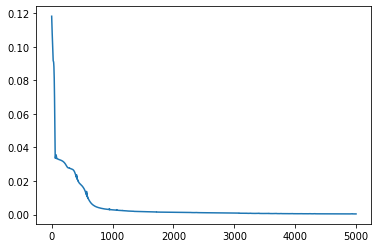

In [42]:
imsize = (32, 32)
n_steps = 5000
log_steps = 500
device = colab_utils.get_device()

coordinates = torch.tensor(generate_input_image(imsize)).to(device)
target_img = colab_utils.load_image('/tmp/Eugen.jpg', size=imsize).to(device)
# Batch the target_img into a dummy batch of size 1 to feed into the model.
target_img = target_img.unsqueeze(0)
model = random_fcnn(n_layers, n_units, activation=nn.Tanh).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters())

losses = []
running_loss = 0
for i in range(n_steps):
  optimizer.zero_grad()
  preds = model(coordinates)
  preds = preds.reshape((1, *imsize, -1)).permute([0, 3, 1, 2])
  loss = criterion(preds, target_img)
  running_loss += loss.item()
  losses.append(loss.item())
  loss.backward()
  optimizer.step()

  if (i+1) % log_steps == 0:
    print(f'{[i+1]}: loss={running_loss / log_steps}')
    running_loss = 0
 
plt.plot(range(len(losses)), losses)

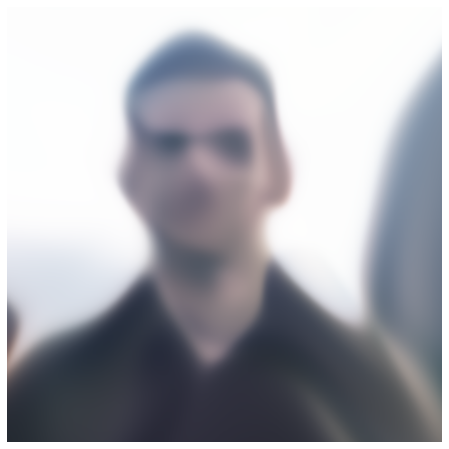

In [43]:
output_imsize = (480, 480)
coordinates = torch.tensor(generate_input_image(imsize=output_imsize)).to(device)
image = model(coordinates)
image = reshape_output_image(image, imsize=output_imsize)
colab_utils.imshow(image, figsize=(8, 8))